<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/music_speech_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: [Classifying Music and Speech with Machine Learning](https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e)

11/2 Update:
- Enabled variable input sample number
- Rewrote all code by myself in modern TF and Keras
- Tried majority-voting instead of FIR filter, and it works better, but FPR still too high.

- Next step: try vocal separation before feeding into NN.  


In [1]:
####################
# Import libraries #
####################

from google.colab import drive
drive.mount("/content/drive")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras

import os

Mounted at /content/drive


In [2]:
#############################
# Load xxm_splitted dataset #
#############################

def get_waveforms_labels(fp, INPUT_SIZE):
  def _get_waveform(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio)

  def _get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

  waveforms = []
  labels = []
  for dirname, _, filenames in os.walk(fp):
      if "xxm_singing" in dirname or "xxm_speech" in dirname:
          print(dirname, filenames)
          for filename in filenames:
            filepath = os.path.join(dirname, filename)
            for i in range(661500 // INPUT_SIZE):
              waveforms.append(_get_waveform(filepath)[i*INPUT_SIZE : (i+1)*INPUT_SIZE])
              labels.append(_get_label(filepath))
  return waveforms, labels

CHUNK_SAMPLE = 661500 // 5

fp = "/content/drive/My Drive/Colab Notebooks/ECE539_Project"
categories = ["xxm_speech", "xxm_singing"]
waveforms, labels = get_waveforms_labels(fp, CHUNK_SAMPLE)

# Merge to tfds
_ds = tf.data.Dataset.from_tensor_slices((waveforms, labels))
waveform_ds = _ds.shuffle(buffer_size=len(_ds))

/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_singing ['4.wav', '0.wav', '3.wav', '1.wav', '2.wav', '5.wav', '14.wav', '8.wav', '7.wav', '13.wav', '12.wav', '9.wav', '10.wav', '6.wav', '15.wav', '16.wav', '11.wav', '21.wav', '23.wav', '19.wav', '20.wav', '18.wav', '22.wav', '25.wav', '24.wav', '17.wav', '35.wav', '31.wav', '32.wav', '33.wav', '26.wav', '27.wav', '34.wav', '30.wav', '28.wav', '29.wav', '41.wav', '43.wav', '40.wav', '36.wav', '42.wav', '38.wav', '39.wav', '37.wav', '49.wav', '50.wav', '48.wav', '52.wav', '45.wav', '47.wav', '44.wav', '51.wav', '46.wav', '58.wav', '59.wav', '53.wav', '54.wav', '60.wav', '61.wav', '56.wav', '55.wav', '57.wav', '62.wav', '70.wav', '64.wav', '63.wav', '67.wav', '71.wav', '66.wav', '68.wav', '65.wav', '69.wav', '81.wav', '76.wav', '80.wav', '72.wav', '73.wav', '78.wav', '79.wav', '82.wav', '77.wav', '75.wav', '74.wav', '91.wav', '89.wav', '90.wav', '87.wav', '85.wav', '86.wav', '83.wav', '88.wav', '84.wav', '94.wav', '95.wav', '9

In [3]:
##########################
# Check waveform dataset #
##########################
import IPython

for i in waveform_ds.take(5):
  ret = IPython.display.Audio(i[0], rate=22050)
  print(i[1])
  IPython.display.display(ret)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_speech', shape=(), dtype=string)
tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


tf.Tensor(b'xxm_singing', shape=(), dtype=string)


In [4]:
##########################
# Convert to spectrogram #
##########################

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def get_spectrograms_labels(waveform, label):
  return tf.expand_dims(get_spectrogram(waveform), -1), tf.argmax(label == categories)

spectrogram_ds = waveform_ds.map(get_spectrograms_labels)
print(len(spectrogram_ds))

for i in spectrogram_ds:
  print(i[0].shape, i[1])
  break

1370
(1032, 129, 1) tf.Tensor(0, shape=(), dtype=int64)


In [14]:
for i in spectrogram_ds.take(1):
  print(i[1])

tf.Tensor(0, shape=(), dtype=int64)


In [15]:
batch_size = 32 # WHY?

train_ds, val_ds = keras.utils.split_dataset(spectrogram_ds, left_size=0.8)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

for _ in spectrogram_ds.take(1):
  input_shape = _[0].shape

for _ in train_ds.take(1):
  b_input_shape = _[0].shape

print('Unbatched input shape:', input_shape)
print('Batched input shape:', b_input_shape)

Unbatched input shape: (1032, 129, 1)
Batched input shape: (32, 1032, 129, 1)


In [8]:
for i in train_ds.take(1):
  print(i[1])

tf.Tensor([0 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0], shape=(32,), dtype=int64)


In [7]:
tf.keras.backend.clear_session()

norm_layer = keras.layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

# Resizing is the hyper param to be tuned.

model = keras.models.Sequential()
model.add(keras.layers.Input(shape=input_shape))
model.add(keras.layers.Resizing(512, 64))
model.add(norm_layer)
model.add(keras.layers.Conv2D(32, 3, activation='relu'))
model.add(keras.layers.Conv2D(64, 3, activation='relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 512, 64, 1)        0         
                                                                 
 normalization (Normalizati  (None, 512, 64, 1)        3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 510, 62, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 508, 60, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 254, 30, 64)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 254, 30, 64)       0

In [8]:
model.compile(optimizer="adam",
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics="accuracy")

EPOCHS = 10
checkpoint_filepath = f"/content/drive/My Drive/Colab Notebooks/ECE539_Project/ms_clf_weights_N={CHUNK_SAMPLE}"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = keras.callbacks.EarlyStopping(verbose=1, patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_callback, earlystop_callback],
)

Epoch 1/10
35/35 [==============================] - 18s 201ms/step - loss: 1.4046 - accuracy: 0.8577 - val_loss: 0.1999 - val_accuracy: 0.9197
Epoch 2/10
35/35 [==============================] - 8s 222ms/step - loss: 0.1515 - accuracy: 0.9516 - val_loss: 0.0971 - val_accuracy: 0.9635
Epoch 3/10
35/35 [==============================] - 6s 177ms/step - loss: 0.0934 - accuracy: 0.9745 - val_loss: 0.0619 - val_accuracy: 0.9745
Epoch 4/10
35/35 [==============================] - 8s 238ms/step - loss: 0.0682 - accuracy: 0.9772 - val_loss: 0.0415 - val_accuracy: 0.9818
Epoch 5/10
35/35 [==============================] - 7s 189ms/step - loss: 0.0605 - accuracy: 0.9772 - val_loss: 0.0391 - val_accuracy: 0.9927
Epoch 6/10
35/35 [==============================] - 8s 234ms/step - loss: 0.0505 - accuracy: 0.9854 - val_loss: 0.0332 - val_accuracy: 0.9964
Epoch 7/10
35/35 [==============================] - 3s 98ms/step - loss: 0.0371 - accuracy: 0.9881 - val_loss: 0.0301 - val_accuracy: 0.9964
Epoch 

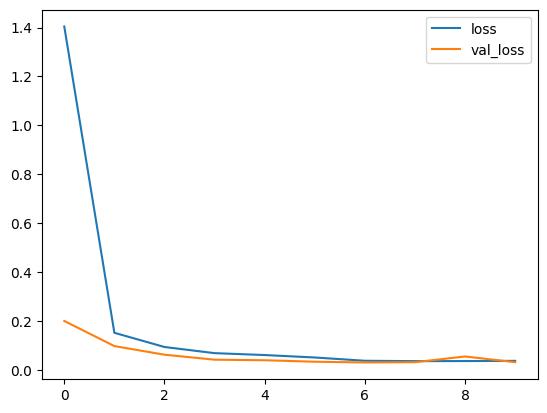

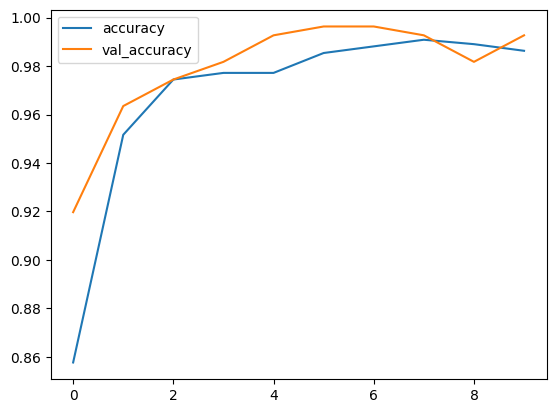

In [9]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [10]:
drive.flush_and_unmount()